In [1]:
!pip install --upgrade diffusers==0.12.1 transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00


In [5]:
from typing import Optional, Union, Tuple

from PIL import Image
import requests
import torch
import string
import random

from transformers import CLIPProcessor, CLIPModel
from transformers.models.clip.modeling_clip import CLIPOutput

import torchvision.transforms as T

from diffusers import StableDiffusionPipeline
from diffusers import schedulers

In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

model = model.to("cuda:0")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
# model_id = "SG161222/Realistic_Vision_V5.1_noVAE" # better for realism
model_id = "Lykon/dreamshaper-8"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.scheduler = schedulers.DDIMScheduler.from_config(pipe.scheduler.config)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'force_upcast': True, 'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint at /root/.cache/huggingface/diffusers/models--Lykon--dreamshaper-8/snapshots/63591bedbcae5cab9fbda622f523d79bcdc92ac9/vae were not used when initializing AutoencoderKL: ['decoder.mid_block.attentions.0.to_k.weight', 'decoder.mid_block.attentions.0.to_k.bias', 'encoder.mid_block.attentions.0.to_out.0.weight', 'decoder.mid_block.attentions.0.to_q.weight', 'encoder.mid_block.attentions.0.to_k.weight', 'decoder.mid_block.attentions.0.to_v.weight', 'encoder.mid_block.

In [8]:
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: int = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)

def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)


def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))


def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

In [9]:
def get_text_outputs(model, input_ids, mask, emb_to_train):

  input_shape = input_ids.shape

  casual_mask = _make_causal_mask(input_shape, emb_to_train.dtype,
                                  device=emb_to_train.device)

  encoded = model.text_model.encoder(emb_to_train,
                                    attention_mask=_expand_mask(mask,
                                                                dtype=emb_to_train.dtype),
                                    causal_attention_mask = casual_mask)
  last_hidden_state = encoded[0]
  last_hidden_state = model.text_model.final_layer_norm(last_hidden_state)
  pooled_output = last_hidden_state[
      torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
      input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
  ]
  return last_hidden_state, pooled_output

In [60]:
class TrainModel(torch.nn.Module):

    def forward(
        self,
        model,
        emb_to_train,
        image_embeds = None,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CLIPOutput]:

        self.model = model
        output_attentions = output_attentions if output_attentions is not None else self.model.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.model.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

        if image_embeds is None:
          vision_outputs = self.model.vision_model(
              pixel_values=pixel_values,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )


          image_embeds = vision_outputs[1]

        image_embeds = self.model.visual_projection(image_embeds)

        text_outputs = get_text_outputs(
            self.model,
            input_ids,
            attention_mask,
            emb_to_train,
        )

        text_embeds = text_outputs[1]
        text_embeds = self.model.text_projection(text_embeds)

        # normalized features
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.model.logit_scale.exp()
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
        logits_per_image = logits_per_text.t()

        loss = 1. - torch.sigmoid(logits_per_image / 32)
        # loss = ((text_embeds - image_embeds) ** 2).sum()

        return loss, text_outputs

In [79]:
class ImageMixer:

  def __init__(self, processor, model, pipe, device="cuda:0"):
    self.pipe = pipe
    self.device = device
    self.processor = processor
    self.model = model
    self.train_model = TrainModel().to(self.device)

    self.resizer = T.Resize(512)
    self.transforms = T.Compose([
        T.ColorJitter(brightness=.5, hue=.1),
        T.Resize(512),
        T.RandomHorizontalFlip(p=0.5),
    ])

  def process(self,
              urls,
              assumption=None,
              steps=30,
              use_augmentation = True,
              lr=0.0003,
              use_negative=True,
              sd_kwargs=None):
      images = [Image.open(requests.get(url, stream=True).raw) for url in urls]
      images = [self.resizer(img) for img in images]
      print(f"process {len(images)} images")

      if not assumption:
        start_prompt = "photo or art of some funny subject + other funny subject, details, details"
      else:
        start_prompt = assumption

      inputs = self.processor(text=[start_prompt], images=images, return_tensors="pt", padding=True)
      inputs["pixel_values"] = inputs["pixel_values"].to(self.device)
      inputs["input_ids"] = inputs["input_ids"].to(self.device)
      inputs['attention_mask'] = inputs['attention_mask'].to(self.device)
      outputs = self.model(**inputs)

      if use_negative:
        negative_prompt = "porn, blurry, bad quality image, low quality image, nude"
        negative_inputs = self.processor(text=[negative_prompt],
                                          images=images,
                                          return_tensors="pt",
                                          padding=True)
        negative_inputs["input_ids"] = inputs["input_ids"].to(self.device)
        negative_inputs['attention_mask'] = inputs['attention_mask'].to(self.device)

        negative_emb = self.model.text_model.embeddings(
            input_ids = negative_inputs["input_ids"])

      emb = self.model.text_model.embeddings(input_ids = inputs["input_ids"])
      emb.shape

      vision_emb = outputs["vision_model_output"][1]

      with torch.enable_grad():
        emb_var = emb.clone().detach().to(self.device)
        # emb_var = torch.randn(emb.shape).to("cuda:0")
        emb_var.requires_grad = True

        optimizer = torch.optim.Adam([emb_var], lr=lr)

        for i in range(steps):
          print(i)
          optimizer.zero_grad()

          image_embeds = None
          cur_ind = i % len(images)

          if use_augmentation:
            work_image = images[cur_ind]
            augmented_image = self.transforms(work_image)
            images_to_prepare = [augmented_image]
            aug_inputs = processor(text=[""],
                  images=images_to_prepare,
                  return_tensors="pt",
                  padding=True)
            inputs['pixel_values'] = aug_inputs['pixel_values'].to(self.device)
          else:
            image_embeds = vision_emb[cur_ind].detach().clone()

          loss, text_outputs = self.train_model(self.model,
                                                emb_var,
                                                image_embeds=image_embeds,
                                                **inputs)

          if use_negative:
            neg_anti_diff = 1 / (0.1 + ((emb_var - negative_emb.detach().clone()) ** 2).mean())
            final_loss = loss + neg_anti_diff

          else:
            final_loss = loss

          final_loss.backward()

          optimizer.step()

          print("loss: ", loss)
          change = ((emb_var - emb)**2).sum()
          print("embedding change: ", change)


      if not sd_kwargs:
        sd_kwargs = {"num_inference_steps": 35, "guidance_scale": 10}
        # self.pipe.run_safety_checker = lambda x, y, z: x, False
        # sd_kwargs["negative_prompt_embeds"] = negative_emb

      images_out = []
      for _ in range(4):
        images_out += pipe(prompt_embeds=text_outputs[0][0:1], **sd_kwargs).images

      return images_out

In [80]:
mixer = ImageMixer(processor=processor,
                   model=model,
                   pipe=pipe)

In [81]:
gigachad_url = "https://upload.wikimedia.org/wikipedia/ru/9/94/%D0%93%D0%B8%D0%B3%D0%B0%D1%87%D0%B0%D0%B4.jpg"
shrek_url = "https://www.the-sun.com/wp-content/uploads/sites/6/2023/08/nk_ShrekRevenge_offplatform.jpg?w=620"

process 2 images
0
loss:  tensor([[0.4036]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0003, device='cuda:0', grad_fn=<SumBackward0>)
1
loss:  tensor([[0.3431]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0009, device='cuda:0', grad_fn=<SumBackward0>)
2
loss:  tensor([[0.4020]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0017, device='cuda:0', grad_fn=<SumBackward0>)
3
loss:  tensor([[0.3386]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0027, device='cuda:0', grad_fn=<SumBackward0>)
4
loss:  tensor([[0.3759]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0039, device='cuda:0', grad_fn=<SumBackward0>)
5
loss:  tensor([[0.3319]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0053, device='cuda:0', grad_fn=<SumBackward0>)
6
loss:  tensor([[0.3606]], device='cuda:0', grad_fn=<RsubBackward1>)
embedding change:  tensor(0.0068, device='c

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


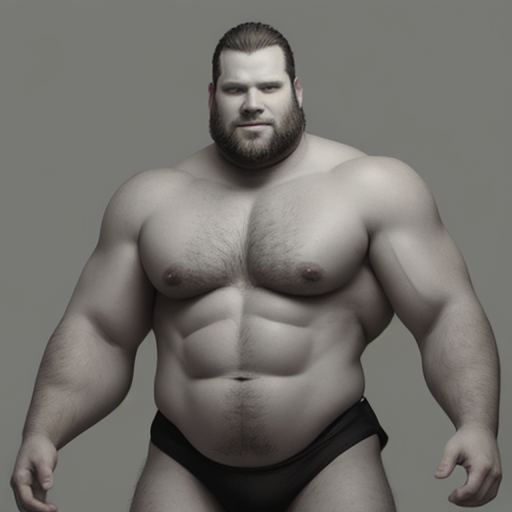

In [117]:
img_out = mixer.process([gigachad_url, shrek_url],
                        use_augmentation=True,
                        steps=60,
                        lr=0.0003,
                        use_negative=True,
                        assumption="man green monster")
img_out[0]

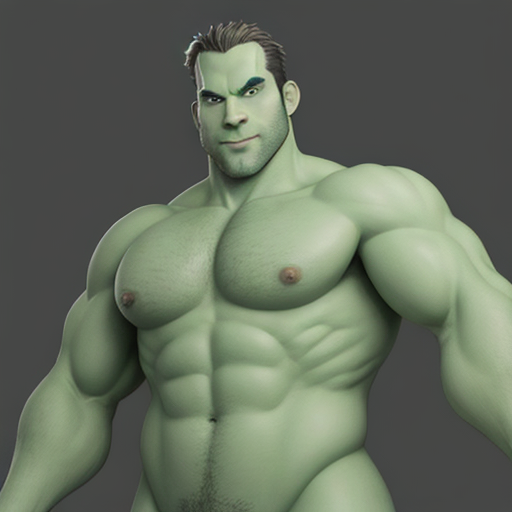

In [118]:
img_out[1]

In [ ]:
# Assumption without algorithm

  0%|          | 0/50 [00:00<?, ?it/s]

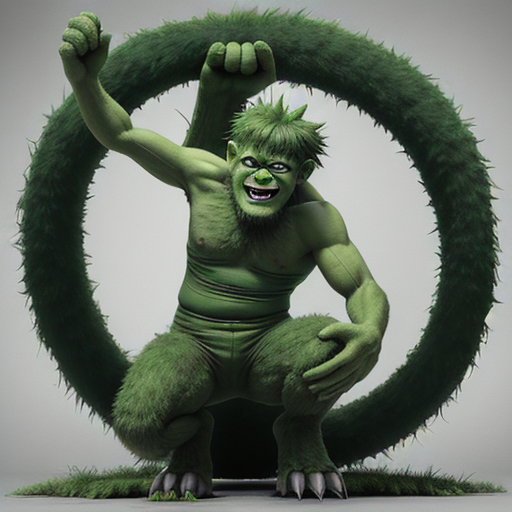

In [116]:
image_out = pipe(prompt="man, green monster", guidance_scale=10).images[0]

image_out